In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations

In [2]:
COLUMNS_STR = """    user_id
    public
    completion_percentage
    gender
    region
    last_login
    registration
    AGE
    body
    I_am_working_in_field
    spoken_languages
    hobbies
    I_most_enjoy_good_food
    pets
    body_type
    my_eyesight
    eye_color
    hair_color
    hair_type
    completed_level_of_education
    favourite_color
    relation_to_smoking
    relation_to_alcohol
    sign_in_zodiac
    on_pokec_i_am_looking_for
    love_is_for_me
    relation_to_casual_sex
    my_partner_should_be
    marital_status
    children
    relation_to_children
    I_like_movies
    I_like_watching_movie
    I_like_music
    I_mostly_like_listening_to_music
    the_idea_of_good_evening
    I_like_specialties_from_kitchen
    fun
    I_am_going_to_concerts
    my_active_sports
    my_passive_sports
    profession
    I_like_books
    life_style
    music
    cars
    politics
    relationships
    art_culture
    hobbies_interests
    science_technologies
    computers_internet
    education
    sport
    movies
    travelling
    health
    companies_brands
    more"""
COLUMNS_LIST = [col.strip() for col in COLUMNS_STR.split("\n")]

In [3]:
def select_relevant_profiles(all_profiles):
    """Select relevant profiles
    criteria:
    * is public
    * region is selected region
    * AGE specified
    * GENDER SPECIFIED
    """
    public_condition = all_profiles["public"] == 1
    age_condition = all_profiles["AGE"] > 14
    gender_condition = all_profiles["gender"].isin([0, 1])
    return all_profiles.loc[public_condition & age_condition & gender_condition]

In [4]:
def select_relevant_edges(all_edges, selected_ids):
    """Select relevant edges for those profiles that are relevant"""
    source_condition = all_edges["source"].isin(selected_ids)
    sink_condition = all_edges["sink"].isin(selected_ids)
    return all_edges.loc[source_condition & sink_condition]

In [5]:
def convert_edges_to_undirected(edges):
    """Convert edges to undirected, and keep only mutual connections"""
    undirected_edges = (
        edges.assign(
            smaller_id=lambda df: df[["source", "sink"]].min(axis=1),
            greater_id=lambda df: df[["source", "sink"]].max(axis=1),
        )
        .groupby(["smaller_id", "greater_id"])
        .agg({"source": "count"})
    )
    print(undirected_edges["source"].value_counts())
    return (
        undirected_edges.loc[undirected_edges["source"] == 2]
        .drop("source", axis=1)
        .reset_index()
    )

In [6]:
def remove_test_set_gender_and_age(nodes):
    """Remove the gender feature from a subset of the nodes for estimation"""
    # todo: the 40k  random can be adjusted if youre working with a subset
    test_profiles = np.random.choice(nodes["user_id"].unique(), 40000, replace=False)
    nodes["TRAIN_TEST"] = "TRAIN"
    test_condition = nodes["user_id"].isin(test_profiles)
    nodes.loc[test_condition, ["AGE", "gender"]] = np.nan
    nodes.loc[test_condition, ["TRAIN_TEST"]] = "TEST"

    return nodes

In [120]:
def load_and_select_profiles_and_edges(full="N"):
    """load and select relevant profiles, then filter and undirect edges"""
    print("loading profiles")
    # TODO: Add some functionality to only read a subset of the data!
    profiles = pd.read_csv(
        "data/soc-pokec-profiles.txt.gz",
        sep="\t",
        names=COLUMNS_LIST,
        index_col=False,
        usecols=["user_id", "public", "gender", "region", "AGE"],
    )
    print("loading edges")
    edges = pd.read_csv(
        "data/soc-pokec-relationships.txt.gz", sep="\t", names=["source", "sink"]
    )
    selected_profiles = select_relevant_profiles(profiles)
    selected_ids = selected_profiles["user_id"].unique()
    selected_edges = select_relevant_edges(edges, selected_ids)
    undirected_edges = convert_edges_to_undirected(selected_edges)
    nodes_with_edges = set(undirected_edges["smaller_id"].unique()).union(
        undirected_edges["greater_id"].unique()
    )
    print(f"Selected profiles: {len(selected_profiles)}")
    print(f"Nodes with edges: {len(nodes_with_edges)}")
    selected_profiles = selected_profiles[
        selected_profiles["user_id"].isin(nodes_with_edges)
    ]
    selected_profiles["AGE"] = selected_profiles["AGE"].clip(upper=50)
    if full== "N":
        selected_profiles = remove_test_set_gender_and_age(selected_profiles)
    
    return selected_profiles, undirected_edges

In [8]:
def create_graph_from_nodes_and_edges(nodes, edges):
    """Create a networkx graph object with all relevant features"""
    node_attributes = nodes.set_index("user_id").to_dict(orient="index")
    node_attributes_list = [
        (index, attr_dict) for index, attr_dict in node_attributes.items()
    ]
    G = nx.Graph()
    G.add_nodes_from(node_attributes_list)
    G.add_edges_from(edges.values.tolist())
    return G

In [9]:
def add_node_features_to_edges(nodes, edges):
    """Add features of nodes to edges in order to create heatmaps"""
    # TODO: column names could be nicer!
    edges_w_features = edges.merge(
        nodes[["user_id", "AGE", "gender"]].set_index("user_id"),
        how="left",
        left_on="smaller_id",
        right_index=True,
    )
    edges_w_features = edges_w_features.merge(
        nodes[["user_id", "AGE", "gender"]].set_index("user_id"),
        how="left",
        left_on="greater_id",
        right_index=True,
    )
    return edges_w_features

In [10]:
def plot_degree_distribution(G):
    """Plot a degree distribution of a graph
    TODO: log-log binning! To understand this better, check out networksciencebook.com
    """
    plot_df = (
        pd.Series(dict(G.degree)).value_counts().sort_index().to_frame().reset_index()
    )
    plot_df.columns = ["k", "count"]
    plot_df["log_k"] = np.log(plot_df["k"])
    plot_df["log_count"] = np.log(plot_df["count"])
    fig, ax = plt.subplots()
    ax.scatter(plot_df["k"], plot_df["count"])
    ax.set_xscale("log")
    ax.set_yscale("log")
    fig.suptitle("Mutual Degree Distribution")
    ax.set_xlabel("k")
    ax.set_ylabel("count_k")

In [11]:
def plot_age_distribution_by_gender(nodes):
    """Plot a histogram where the color represents gender"""
    plot_df = nodes[["AGE", "gender"]].copy(deep=True).astype(float)
    plot_df["gender"] = plot_df["gender"].replace({0.0: "woman", 1.0: "man"})
    sns.histplot(data=plot_df, x="AGE", hue="gender", bins=np.arange(0, 45, 5) + 15)

In [12]:
def plot_node_degree_by_gender(nodes, G):
    """Plot the average of node degree across age and gender"""
    nodes_w_degree = nodes.set_index("user_id").merge(
        pd.Series(dict(G.degree)).to_frame(),
        how="left",
        left_index=True,
        right_index=True,
    )
    nodes_w_degree = nodes_w_degree.rename({0: "degree"}, axis=1)
    plot_df = (
        nodes_w_degree.groupby(["AGE", "gender"]).agg({"degree": "mean"}).reset_index()
    )
    plot_df["gender"] = plot_df["gender"].replace({0.0: "woman", 1.0: "man"})
    sns.lineplot(data=plot_df, x="AGE", y="degree", hue="gender")

In [13]:
def plot_node_average_neighbor_degree_by_gender(nodes, G):
    """Plot the average of node average_neighbor_degree across age and gender"""
    nodes_w_average_neighbor_degree = nodes.set_index("user_id").merge(
        pd.Series(dict(nx.average_neighbor_degree(G))).to_frame(),
        how="left",
        left_index=True,
        right_index=True,
    )
    nodes_w_average_neighbor_degree = nodes_w_average_neighbor_degree.rename({0: "average_neighbor_degree"}, axis=1)
    plot_df = (
        nodes_w_average_neighbor_degree.groupby(["AGE", "gender"]).agg({"average_neighbor_degree": "mean"}).reset_index()
    )
    plot_df["gender"] = plot_df["gender"].replace({0.0: "woman", 1.0: "man"})
    sns.lineplot(data=plot_df, x="AGE", y="average_neighbor_degree", hue="gender")

In [14]:
def plot_node_clustering_by_gender(nodes, G):
    """Plot the average of node clustering across age and gender"""
    nodes_w_clustering = nodes.set_index("user_id").merge(
        pd.Series(dict(nx.clustering(G))).to_frame(),
        how="left",
        left_index=True,
        right_index=True,
    )
    nodes_w_clustering = nodes_w_clustering.rename({0: "clustering"}, axis=1)
    plot_df = (
        nodes_w_clustering.groupby(["AGE", "gender"]).agg({"clustering": "mean"}).reset_index()
    )
    plot_df["gender"] = plot_df["gender"].replace({0.0: "woman", 1.0: "man"})
    sns.lineplot(data=plot_df, x="AGE", y="clustering", hue="gender")

In [15]:
def plot_age_relations_heatmap(edges):
    """Plot a heatmap that represents the distribution of edges"""
    plot_df = edges.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    plot_df_w_w = plot_df.loc[(0, 0)].reset_index()
    plot_df_heatmap = plot_df_w_w.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    sns.heatmap(plot_df_heatmap_logged)

In [16]:
def plot_age_relations_heatmapv2(edges):
    """Plot a heatmap that represents the distribution of edges"""
    plot_df = edges.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y"]).agg(
        {"smaller_id": "count"}
    )
    plot_df_w_w = plot_df.reset_index()
    plot_df_heatmap = plot_df_w_w.pivot_table(
        index="AGE_x", columns="AGE_y", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    sns.heatmap(plot_df_heatmap_logged)

In [112]:
def predictor_neighbor(node_number):
    
    neighbor_nodes = set()
    
    for n in network.neighbors(node_number):
        neighbor_nodes.add(n)
        
    m = 0
    f = 0
    
    for i in neighbor_nodes:
        if pd.notnull(s_profiles.loc[i]["gender"]):
            if s_profiles.loc[i]["gender"]==0:
                f+=1
            else:
                m+=1
    if (m+f)==0:
        prediction = "NA"
    else:
        prediction = round(m/(m+f))

    return(prediction)

In [18]:
def genderfilter(genders):
    if genders=="FF":
        filtered_df = edges_with_features[(edges_with_features['gender_x']== 0) &
                                              (edges_with_features['gender_y']== 0)]
    if genders=="FM" or genders=="MF":
        filtered_df = edges_with_features[(edges_with_features['gender_x'] !=
                                              edges_with_features['gender_y']) & 
                                              (pd.notnull(edges_with_features['gender_x'])) & 
                                              (pd.notnull(edges_with_features['gender_y']))]
    if genders=="MM":
        filtered_df = edges_with_features[(edges_with_features['gender_x']== 1) &
                                              (edges_with_features['gender_y']== 1)]
    return(filtered_df)

In [19]:
def plot_age_relations_heatmap_genderdiff(edges):
    plot_df = edges.groupby(["gender_x", "gender_y", "AGE_x", "AGE_y", "type"]).agg(
                {"smaller_id": "count"})

    plot_df.reset_index(level="type", inplace=True)
    plot_df.reset_index(level="AGE_y", inplace=True)
    
    plot_df["gender_AGE"]=plot_df["AGE_y"]*plot_df["type"]
    
    plot_df_w_w = plot_df.reset_index()
    plot_df_heatmap = plot_df_w_w.pivot_table(
        index="gender_AGE", columns="AGE_x", values="smaller_id"
    ).fillna(0)
    plot_df_heatmap_logged = np.log(plot_df_heatmap + 1)
    sns.heatmap(plot_df_heatmap_logged)

In [20]:
def neighbor_age_differences(node_number):

    neighbor_nodes = set()
    
    for n in network.neighbors(node_number):
        neighbor_nodes.add(n)

    ss_neighbor_age = []
    ds_neighbor_age = []
    
    for k in neighbor_nodes:
        if pd.notnull(s_profiles.loc[node_number]["gender"]) and pd.notnull(s_profiles.loc[k]["gender"]):
            
            if s_profiles.loc[node_number]["gender"]==s_profiles.loc[k]["gender"]:
                ss_neighbor_age.append(s_profiles.loc[k]["AGE"])
            else:
                ds_neighbor_age.append(s_profiles.loc[k]["AGE"])
    
    ss_neighbor_age = abs(ss_neighbor_age-s_profiles.loc[node_number]["AGE"])
    ds_neighbor_age = abs(ds_neighbor_age-s_profiles.loc[node_number]["AGE"])
    
    sl5,sl10,sl20=0,0,0
    dl5,dl10,dl20=0,0,0
    
    for y in ss_neighbor_age:
        if y<5:
            sl5+=1
        if y>=5 and y<10:
            sl10+=1
        if y>=10 and y<20:
            sl20+=1
            
    for x in ds_neighbor_age:
        if x<5:
            dl5+=1
        if x>=5 and x<10:
            dl10+=1
        if x>=10 and x<20:
            dl20+=1
                
    portion=np.array([sl5,sl10,sl20,dl5,dl10,dl20])/(sl5+sl10+sl20+dl5+dl10+dl20)

    return(portion)

In [21]:
'''def neighbor_age_differences(node_number):

    neighbor_nodes = set()
    
    for n in network.neighbors(node_number):
        neighbor_nodes.add(n)

    neighbor_age = []
    
    for i in neighbor_nodes:
        neighbor_age.append(s_profiles.loc[i]["AGE"])
    
    neighbor_age = abs(neighbor_age-s_profiles.loc[node_number]["AGE"])
    
    l5,l10,l20=0,0,0
    
    for y in neighbor_age:
        if pd.notnull(y):
            if y<5:
                l5+=1
            if y>=5 and y<10:
                l10+=1
            if y>=10 and y<20:
                l20+=1
                
    portion=np.array([l5,l10,l20])/(l5+l10+l20)

    return(portion)'''

'def neighbor_age_differences(node_number):\n\n    neighbor_nodes = set()\n    \n    for n in network.neighbors(node_number):\n        neighbor_nodes.add(n)\n\n    neighbor_age = []\n    \n    for i in neighbor_nodes:\n        neighbor_age.append(s_profiles.loc[i]["AGE"])\n    \n    neighbor_age = abs(neighbor_age-s_profiles.loc[node_number]["AGE"])\n    \n    l5,l10,l20=0,0,0\n    \n    for y in neighbor_age:\n        if pd.notnull(y):\n            if y<5:\n                l5+=1\n            if y>=5 and y<10:\n                l10+=1\n            if y>=10 and y<20:\n                l20+=1\n                \n    portion=np.array([l5,l10,l20])/(l5+l10+l20)\n\n    return(portion)'

In [132]:
s_profiles,s_edges=load_and_select_profiles_and_edges()
full_profiles,full_edges=load_and_select_profiles_and_edges("Y")

loading profiles
loading edges
1    2642113
2    1992414
Name: source, dtype: int64
Selected profiles: 695406
Nodes with edges: 434590
loading profiles
loading edges
1    2642113
2    1992414
Name: source, dtype: int64
Selected profiles: 695406
Nodes with edges: 434590


In [145]:
s_profiles.set_index("user_id",drop=False,inplace=True)
full_profiles.set_index("user_id",drop=False,inplace=True)

,user_id,public,gender,region,AGE
user_id,,,,,
1,1,1,1.0,"zilinsky kraj, zilina",26.0
4,4,1,0.0,"banskobystricky kraj, brezno",26.0
17,17,1,0.0,"zilinsky kraj, martin",27.0
5,5,1,1.0,"zilinsky kraj, zilina",26.0
18,18,1,1.0,"zilinsky kraj, kysucke nove mesto",18.0
31,31,1,1.0,"zilinsky kraj, kysucke nove mesto",24.0
19,19,1,1.0,"zilinsky kraj, kysucke nove mesto",21.0
32,32,1,1.0,"zilinsky kraj, kysucke nove mesto",21.0
7,7,1,0.0,"zilinsky kraj, martin",22.0


In [134]:
network = create_graph_from_nodes_and_edges(s_profiles,s_edges)

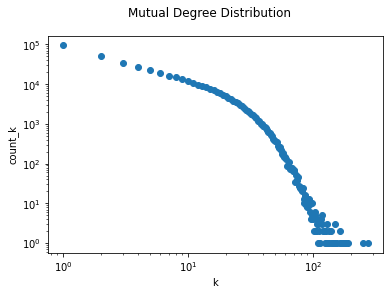

In [135]:
plot_degree_distribution(network)

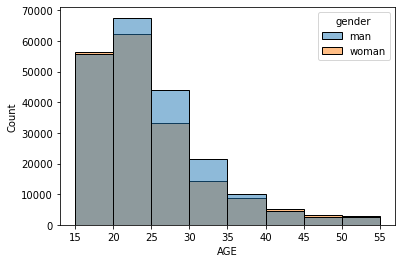

In [136]:
plot_age_distribution_by_gender(s_profiles)

In [137]:
test_set_id = s_profiles[s_profiles.TRAIN_TEST=='TEST']["user_id"].values.tolist()

In [138]:
def triangles(node):
    neighbors1 = set(network.neighbors(node))
    neighbors2 = set(network.neighbors(node))
    
    triangles=set()
    
    for neighbors1, neighbors2 in combinations(network.neighbors(node), 2):
        if network.has_edge(neighbors1, neighbors2):
            triangles.add((neighbors1,neighbors2))
    
    return(triangles)

In [139]:
def predictor_triangles(node):
    
    if nx.triangles(network, node)!=0:
        
        prediction=[]
        for triangle in triangles(node):
            
            m=0
            f=0
            
            for neighbor in triangle:
                if pd.notnull(s_profiles.loc[neighbor]["gender"]):
                    if s_profiles.loc[neighbor]["gender"]==0:
                        f+=1
                    else:
                        m+=1
                prediction.append(m/2)
    
        prediction=round(sum(prediction)/len(prediction))
        
    else:
        prediction=predictor_neighbor(node)
    
    return(prediction)

In [180]:
prediction = pd.DataFrame(test_set_id,columns=['user_id'])
prediction.set_index("user_id",drop=False,inplace=True)

original=full_profiles["gender"]

prediction["original"]=original

In [181]:
prediction["predicted_gender_neighbor"] = prediction.apply(lambda row: predictor_neighbor(row['user_id']), axis=1 )

prediction["predicted_gender_triangle"] = prediction.apply(lambda row: predictor_triangles(row['user_id']), axis=1 )

,user_id,original,predicted_gender_neighbor,predicted_gender_triangle
user_id,,,,
107,107,1.0,0,0
100,100,0.0,0,0
59,59,1.0,0,0
146,146,0.0,1,0
73,73,0.0,1,0
...,...,...,...,...
1632112,1632112,0.0,0,0
1632297,1632297,0.0,1,1
1632506,1632506,1.0,0,0


In [196]:
neighbor_acc=0
triangle_acc=0

for i in prediction.iterrows():
    
    if i[1]["original"]==i[1]["predicted_gender_neighbor"]:
        neighbor_acc+=1
    
    if i[1]["original"]==i[1]["predicted_gender_triangle"]:
        triangle_acc+=1

print(neighbor_acc/len(prediction),triangle_acc/len(prediction))

0.489575 0.503175


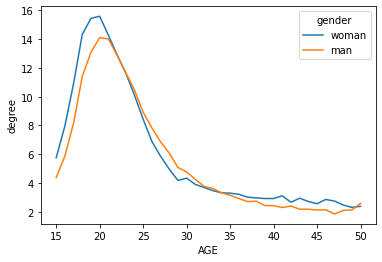

In [29]:
plot_node_degree_by_gender(s_profiles,network)

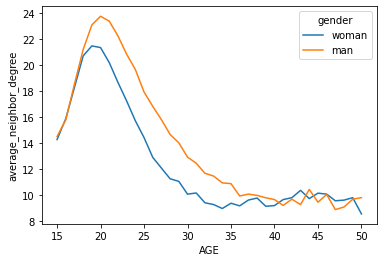

In [30]:
plot_node_average_neighbor_degree_by_gender(s_profiles,network)

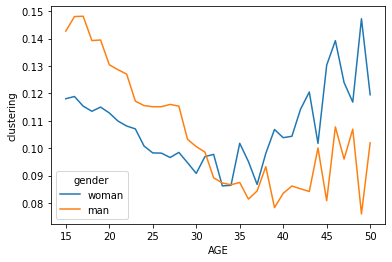

In [31]:
plot_node_clustering_by_gender(s_profiles,network)

In [32]:
edges_with_features = add_node_features_to_edges(s_profiles,s_edges).dropna()

edges_with_features["type"] = edges_with_features.apply(lambda x: 1 if x["gender_y"]==x["gender_x"] else -1, axis=1)

In [33]:
male=pd.concat([genderfilter("MF"),genderfilter("MM")])
female=pd.concat([genderfilter("FF"),genderfilter("FM")])

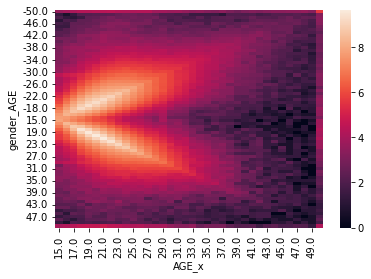

In [34]:
plot_age_relations_heatmap_genderdiff(male)

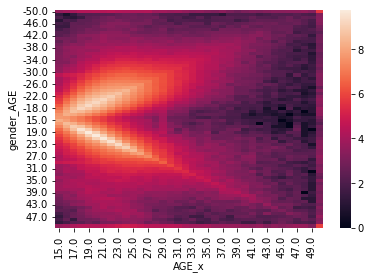

In [35]:
plot_age_relations_heatmap_genderdiff(female)

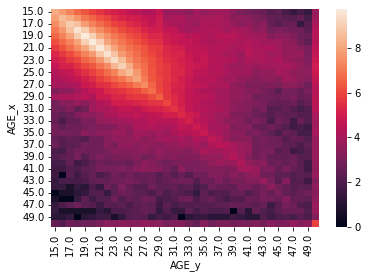

In [36]:
plot_age_relations_heatmap(edges_with_features)

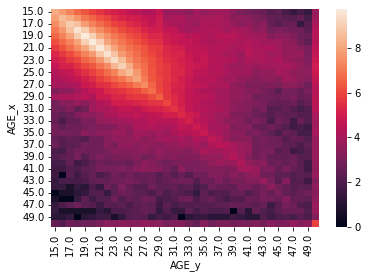

In [37]:
plot_age_relations_heatmapv2(genderfilter("FF"))

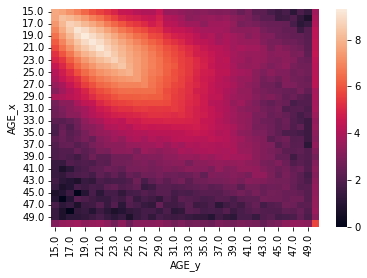

In [38]:
plot_age_relations_heatmapv2(genderfilter("MF"))

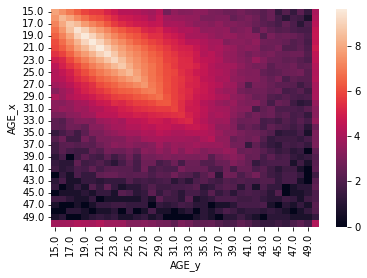

In [39]:
plot_age_relations_heatmapv2(genderfilter("MM"))

In [40]:
neighbor_age_diff = pd.DataFrame(s_profiles).head(10000)

In [41]:
neighbor_age_diff["age_diff"] = neighbor_age_diff.apply(lambda row: neighbor_age_differences(row.name), axis=1 )

C:\Users\Alex\AppData\Local\Temp/ipykernel_8708/1404810708.py:41: RuntimeWarning: invalid value encountered in true_divide
  portion=np.array([sl5,sl10,sl20,dl5,dl10,dl20])/(sl5+sl10+sl20+dl5+dl10+dl20)


In [42]:
print(neighbor_age_diff)

         user_id  public  gender                               region   AGE  \
user_id                                                                       
1              1       1     NaN                zilinsky kraj, zilina   NaN   
4              4       1     0.0         banskobystricky kraj, brezno  26.0   
17            17       1     0.0                zilinsky kraj, martin  27.0   
5              5       1     1.0                zilinsky kraj, zilina  26.0   
18            18       1     1.0    zilinsky kraj, kysucke nove mesto  18.0   
...          ...     ...     ...                                  ...   ...   
25353      25353       1     1.0                zilinsky kraj, zilina  21.0   
25285      25285       1     NaN                 zilinsky kraj, rajec   NaN   
25260      25260       1     1.0                zilinsky kraj, zilina  25.0   
25354      25354       1     1.0                 zilinsky kraj, bytca  20.0   
25328      25328       1     1.0  trenciansky kraj, 

In [43]:
neighbor_age_diff[['SL5','SL10',"SL20",'DL5','DL10',"DL20"]]=pd.DataFrame(neighbor_age_diff["age_diff"].tolist(), index=neighbor_age_diff.index)

In [44]:
print(neighbor_age_diff)

         user_id  public  gender                               region   AGE  \
user_id                                                                       
1              1       1     NaN                zilinsky kraj, zilina   NaN   
4              4       1     0.0         banskobystricky kraj, brezno  26.0   
17            17       1     0.0                zilinsky kraj, martin  27.0   
5              5       1     1.0                zilinsky kraj, zilina  26.0   
18            18       1     1.0    zilinsky kraj, kysucke nove mesto  18.0   
...          ...     ...     ...                                  ...   ...   
25353      25353       1     1.0                zilinsky kraj, zilina  21.0   
25285      25285       1     NaN                 zilinsky kraj, rajec   NaN   
25260      25260       1     1.0                zilinsky kraj, zilina  25.0   
25354      25354       1     1.0                 zilinsky kraj, bytca  20.0   
25328      25328       1     1.0  trenciansky kraj, 

In [45]:
#g=neighbor_age_diff.groupby(["AGE","gender"]).agg({"L5": "mean","L10": "mean","L20": "mean"}).reset_index()
g=neighbor_age_diff.groupby(["AGE"]).agg({"SL5": "mean","SL10": "mean","SL20": "mean","DL5": "mean","DL10": "mean","DL20": "mean"}).reset_index()

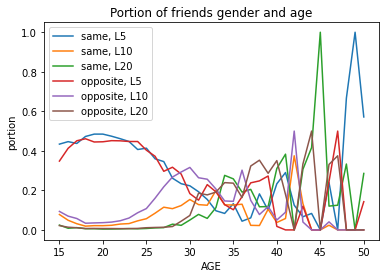

In [46]:
plt.plot(g["AGE"], g["SL5"], label = "same, L5")
plt.plot(g["AGE"], g["SL10"], label = "same, L10")
plt.plot(g["AGE"], g["SL20"], label = "same, L20")
plt.plot(g["AGE"], g["DL5"], label = "opposite, L5")
plt.plot(g["AGE"], g["DL10"], label = "opposite, L10")
plt.plot(g["AGE"], g["DL20"], label = "opposite, L20")
plt.xlabel('AGE')
plt.ylabel('portion')
plt.title("Portion of friends gender and age")
plt.legend()
plt.show()